<a href="https://colab.research.google.com/github/kamalesh003/Land_Cover_Classification/blob/main/Land_Cover_Classification_Using_Satellite_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.8 MB/s eta 0:00:00


In [ ]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

Streaming output truncated to the last 5000 lines.
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
2

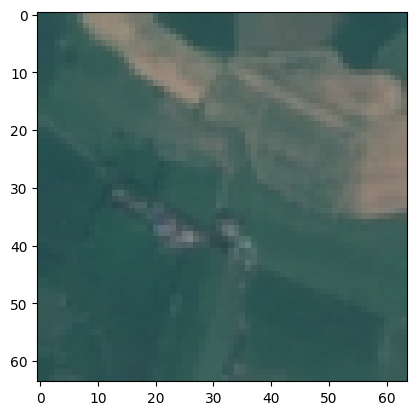

In [ ]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  print(i)
  i += 1

del r # clear memory
del z

# Get labels in numpy array as strings
labs = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  labs[i] = label.split('/')[1]
  i += 1


# change them to integers in alphabetical order
label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T



# test that the labels and images read in properly
tmp = 18000
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

(20000,)
(20000, 64, 64, 3)
b'Forest'


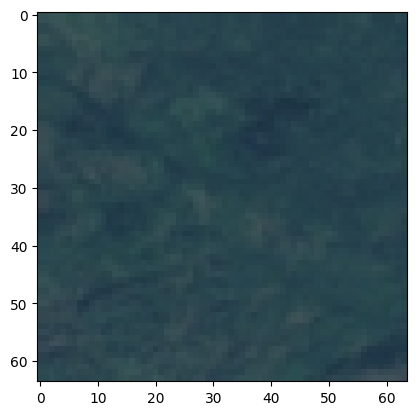

In [ ]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]



# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])



# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)



# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, train_size = 0.8, random_state=42)
# test that the labels and images are still matched up properly
tmp = 7000
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M4.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [ ]:
M4 = Sequential()
M4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
M4.add(Conv2D(64, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))
M4.add(Dropout(0.2))
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(num_classes, activation='softmax'))

M4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               14745856  
                                                        

In [ ]:
M4.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
history = M4.fit(X_train, y_train,
                    batch_size=64,
                    epochs=5,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/5
338/338 [==============================] - ETA: 0s - loss: 1.6417 - accuracy: 0.4195

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


338/338 [==============================] - 476s 1s/step - loss: 1.6417 - accuracy: 0.4195 - val_loss: 1.1200 - val_accuracy: 0.6022
Epoch 2/5
338/338 [==============================] - 481s 1s/step - loss: 1.0461 - accuracy: 0.6229 - val_loss: 0.8593 - val_accuracy: 0.6944
Epoch 3/5
338/338 [==============================] - 465s 1s/step - loss: 0.8043 - accuracy: 0.7114 - val_loss: 0.6212 - val_accuracy: 0.7874
Epoch 4/5
338/338 [==============================] - 469s 1s/step - loss: 0.6788 - accuracy: 0.7668 - val_loss: 0.7081 - val_accuracy: 0.7511
Epoch 5/5
338/338 [==============================] - 470s 1s/step - loss: 0.5606 - accuracy: 0.8082 - val_loss: 0.5924 - val_accuracy: 0.7913


In [ ]:
score = M4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5924096703529358
Test accuracy: 0.7912963032722473


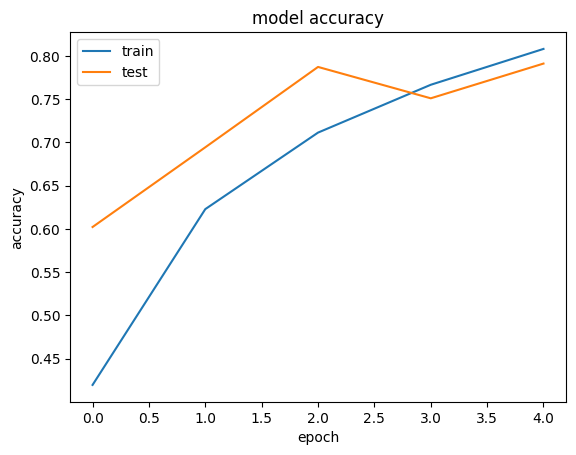

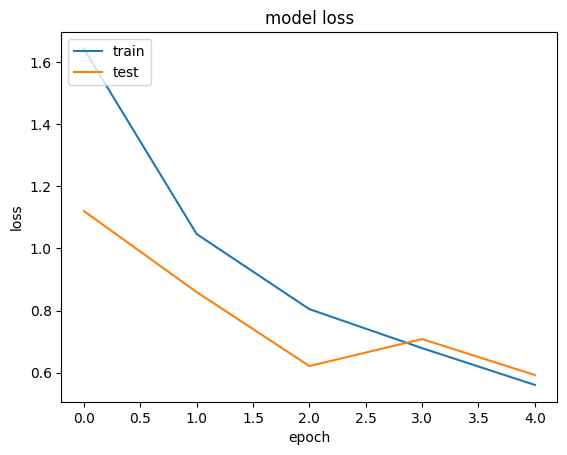

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import requests
import zipfile
import io
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"



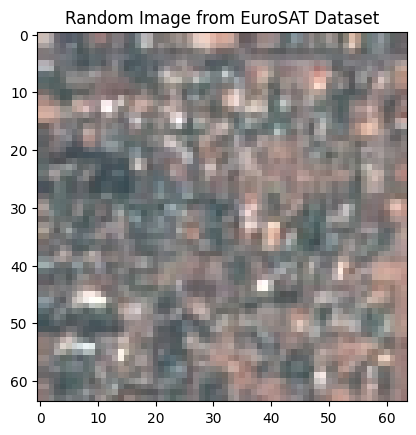

1/1 [==============================] - 0s 138ms/step
Predicted Class Index: 7


In [ ]:

# Download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Get file names
image_files = [file for file in z.namelist() if ".jpg" in file]

# Set the desired image size
image_size = (64, 64)

# Select a random image
random_image_file = np.random.choice(image_files)

# Load the random image
random_image_data = z.read(random_image_file)
random_image = Image.open(io.BytesIO(random_image_data))

# Resize the image
random_image = random_image.resize(image_size)

# Display the random image
plt.imshow(random_image)
plt.title("Random Image from EuroSAT Dataset")
plt.show()

# Preprocess the image for model testing
random_image_array = img_to_array(random_image)
random_image_array = random_image_array.astype('float32') / 255.0
random_image_array = np.expand_dims(random_image_array, axis=0)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M4.h5')

# Make predictions
predictions = loaded_model.predict(random_image_array)

# Display the predicted class
predicted_class = np.argmax(predictions)
print(f"Predicted Class Index: {predicted_class}")


In [ ]:

# Assuming label_Dict is defined
class_name = label_Dict[predicted_class]

# Display the predicted class name
print(f"Predicted Class Name: {class_name}")

Predicted Class Name: b'Residential'
